In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D 
from matplotlib.colors import LinearSegmentedColormap
from skimage import color
from scipy.spatial import ConvexHull

%matplotlib widget

In [ ]:
def plotLAB(output, draw_polygon=True, marker='o'):
    # compute convex hull of the given points
    hull = ConvexHull(output[:, 1:])
    if draw_polygon:

          # connect original points with gradient color
            grandient_density = 100
            for i in range(output.shape[0]):
                pt1, pt2 = output[i], output[(i + 1) % output.shape[0]]
                pt_L = np.linspace(pt1[0], pt2[0], grandient_density)
                pt_a = np.linspace(pt1[1], pt2[1], grandient_density)
                pt_b = np.linspace(pt1[2], pt2[2], grandient_density)
                # create a gradient colormap between two colors
                pt1_rgb = color.lab2rgb(pt1)
                pt2_rgb = color.lab2rgb(pt2)
                cmap = LinearSegmentedColormap.from_list('', [pt1_rgb, pt2_rgb], N=grandient_density)
                # get the color values from the colormap
                color_array = cmap(np.linspace(0, 1, grandient_density))
                # plot each segment as a line with the gradient colormap
                for i in range(grandient_density-1):
                    ax.plot([pt_L[i],pt_L[i+1]], [pt_a[i],pt_a[i+1]], [pt_b[i],pt_b[i+1]], 
                       color=color_array[i],alpha=0.5)
    # plot the original points
    for i in range(output.shape[0]):
        lab = output[i]
        rgb = color.lab2rgb(np.array([lab]))
        rgb = np.clip(rgb, 0, 1)
        ax.scatter(*lab, color=rgb[0], marker=marker)


        
def convert_model_output(arr, value, index):
    arr = np.unique(arr, axis=0)
    arr = np.insert(arr, index, value, axis=1)
    # convert to LAB and adjust L
    lab_colors = arr.copy()
    lab_colors = color.lab2rgb(lab_colors)  # convert to RGB
    lab_colors = np.clip(lab_colors * 255, 0, 255).astype(int)  # convert to integer RGB values
    # create DataFrame with both LAB and RGB columns
    df_lab = pd.DataFrame(arr, columns=['L', 'a', 'b'])
    df_rgb = pd.DataFrame(lab_colors, columns=['R', 'G', 'B'])
    df = pd.concat([df_rgb ,df_lab], axis=1)
    return df

def convert_color_chart(color_codes, to_lab=True, adjust_L=True):
    # parse color codes
    original_codes = color_codes.copy()  
    color_codes = [c.lstrip('#') for c in color_codes]
    # convert to RGB
    rgb_colors = np.array([[int(c[i:i+2], 16) for i in (0, 2, 4)] for c in color_codes]) / 255.0

    if to_lab:
        # convert to LAB
        lab_colors = color.rgb2lab(rgb_colors)
        if adjust_L:
            lab_colors[:, 0] = 50  # adjust L to 50
            rgb_colors = color.lab2rgb(lab_colors) * 255
            rgb_colors = np.clip(rgb_colors, 0, 255)  
        df_rgb = pd.DataFrame(rgb_colors, columns=['R', 'G', 'B'])
        df_lab = pd.DataFrame(lab_colors, columns=['L', 'a', 'b'])
        df = df_lab.join(df_rgb)
    else:
        df_rgb = pd.DataFrame(rgb_colors, columns=['R', 'G', 'B'])
        df = df_rgb
    
    df['Color Code'] = original_codes
    return df[['Color Code', 'R', 'G', 'B', 'L', 'a', 'b']]

def plot_lab_plane(ax, L=50, a_range=(-128, 127, 100), b_range=(-128, 127, 100)):
    A, B = np.meshgrid(np.linspace(*a_range), np.linspace(*b_range))
    L = np.ones_like(A) * L
    lab_plane = np.stack([L, A, B], axis=-1)
    rgb_plane = color.lab2rgb(lab_plane)
    ax.plot_surface(L, A, B, facecolors=rgb_plane, alpha=0.2)

def set_lab_color_space(ax):
    ax.set_xlabel('L')
    ax.set_ylabel('a')
    ax.set_zlabel('b')
    ax.set_xlim3d(0, 100)
    ax.set_ylim3d(-128, 127)
    ax.set_zlim3d(-128, 127)
    plt.show()

### Output Data Preprocessing

In [33]:
# Model Output
output = np.array([[4.79, 81.1], [11.72, 40.82], [10.99, 35.12], [8.01, 58.43], [-6.36, -33.91], [30.93, -45.39], [30.93, -45.39], [30.93, -45.39]])
df_model_output = convert_model_output(output,50,0)
lab_model_output = df_model_output[['L', 'a', 'b']].values.astype(np.float32)
print(lab_model_output)
# Color Charts
color_codes = ['#424B54', '#93A8AC', '#FFFFFF', '#E2B4BD', '#9B6A6C']
df_color_chart = convert_color_chart(color_codes, to_lab=True, adjust_L=False)
lab_color_chart = df_color_chart[['L', 'a', 'b']].values.astype(np.float32)
print(lab_color_chart)

out = lab_model_output
palette = lab_color_chart

[[ 50.    -6.36 -33.91]
 [ 50.     4.79  81.1 ]
 [ 50.     8.01  58.43]
 [ 50.    10.99  35.12]
 [ 50.    11.72  40.82]
 [ 50.    30.93 -45.39]]
[[ 3.1417486e+01 -1.3679246e+00 -6.5394201e+00]
 [ 6.7416412e+01 -6.4388714e+00 -4.5247273e+00]
 [ 1.0000000e+02 -2.4549379e-03  4.6534212e-03]
 [ 7.7571365e+01  1.8000654e+01  1.7927089e+00]
 [ 4.9930618e+01  1.9893671e+01  6.8278799e+00]]


### HSV

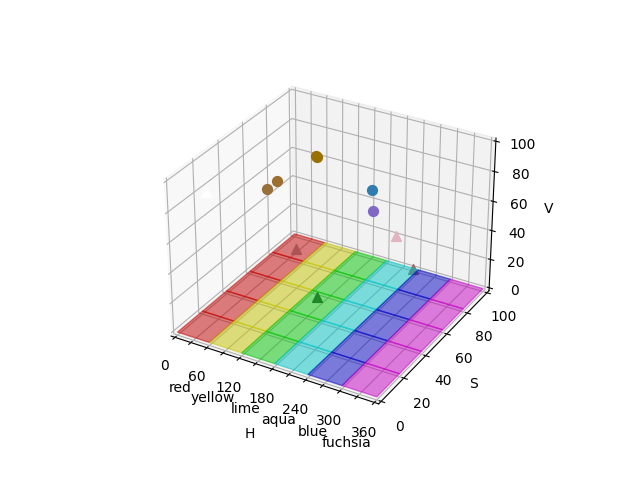

In [85]:
# convert L*a*b -> RGB -> HSV
def lab_to_hsv(out, palette):
    # model output
    out_rgb = np.apply_along_axis(lambda x: color.lab2rgb(x), 1, out)  # convert lab to rgb
    out_rgb = np.clip(out_rgb, 0, 1)
    out_hsv = np.apply_along_axis(lambda x: color.rgb2hsv(x), 1, out_rgb)  # convert rgb to hsv
    out_hsv[:,0] = out_hsv[:,0] * 360  # range of H is 0-360
    out_hsv[:,1:] = out_hsv[:,1:] * 100  # range of S and V is 0-100
    
    # personal color palette
    p_rgb = np.apply_along_axis(lambda x: color.lab2rgb(x), 1, palette)
    p_rgb = np.clip(p_rgb, 0, 1)
    p_hsv = np.apply_along_axis(lambda x: color.rgb2hsv(x), 1, p_rgb)
    p_hsv[:,0] = p_hsv[:,0] * 360
    p_hsv[:,1:] = p_hsv[:,1:] * 100

    # plot 3D hsv
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for RGB, HSV in zip(out_rgb, out_hsv):
        ax.scatter(*HSV, color=RGB, s=50, marker='o')
    for RGB, HSV in zip(p_rgb, p_hsv):
        ax.scatter(*HSV, color=RGB, s=50, marker='^')
        
    # set H label
    ax.set_xticks([0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
    ax.set_xticklabels(['0', '\nred', '60', '\nyellow', '120', '\nlime', '180', '\naqua', '240', '\nblue', '300', '\nfuchsia', '360'])
    
    ax.set_xlabel('\n\nH')
    ax.set_ylabel('S')
    ax.set_zlabel('V')
    ax.set_xlim3d(0, 360)  # 0-360
    ax.set_ylim3d(0, 100)  # 0-100
    ax.set_zlim3d(0, 100)  # 0-100
    
    # plot x plane (H color)
    x = np.arange(0, 360+1, 60)
    y = np.arange(0, 100+1, 20)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros((len(y), len(x)))
    facecolors = np.zeros((len(y), len(x), 4))
    facecolors[:,0,:] = [1, 0, 0, 0.5]
    facecolors[:,1,:] = [1, 1, 0, 0.5]
    facecolors[:,2,:] = [0, 1, 0, 0.5]
    facecolors[:,3,:] = [0, 1, 1, 0.5]
    facecolors[:,4,:] = [0, 0, 1, 0.5]
    facecolors[:,5,:] = [1, 0, 1, 0.5]
    ax.plot_surface(X, Y, Z, facecolors=facecolors)
    
    plt.show()
    
# conver lab to hsv and plot
lab_to_hsv(out, palette)

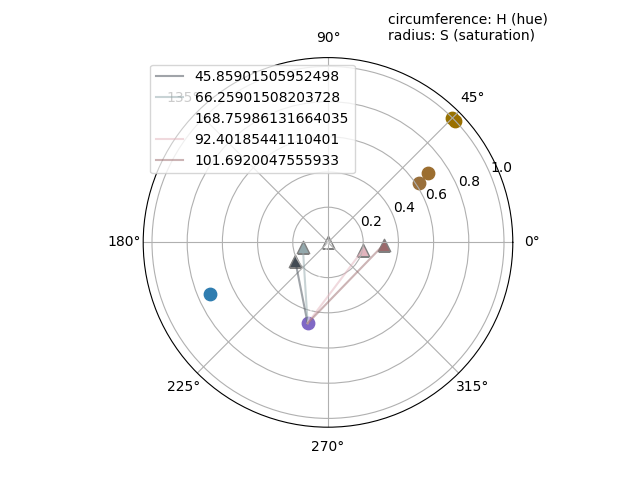

In [125]:
# map the color H to a circle
def h_distance(out, palette):
    # ----------- lab to rgb and hsv -----------
    # model output
    out_rgb = np.apply_along_axis(lambda x: color.lab2rgb(x), 1, out)  # convert lab to rgb
    out_rgb = np.clip(out_rgb, 0, 1)
    out_hsv = np.apply_along_axis(lambda x: color.rgb2hsv(x), 1, out_rgb)  # convert rgb to hsv
    out_h, out_s = out_hsv[:,0] * 360, out_hsv[:,1]  # get H (0-360)
    
    # personal color palette
    p_rgb = np.apply_along_axis(lambda x: color.lab2rgb(x), 1, palette)
    p_rgb = np.clip(p_rgb, 0, 1)
    p_hsv = np.apply_along_axis(lambda x: color.rgb2hsv(x), 1, p_rgb)
    p_h, p_s = p_hsv[:,0] * 360, p_hsv[:,1]
    
    # ----------- hue distance -----------
    # compute the hue distance between each pair of output colors and palettes
    idx = 5
    select_h = [out_h[idx]] * len(p_h)  # select an output color at one time
    diff = np.abs(select_h - p_h)
    diff[diff > 180] = 360 - diff[diff > 180]
    
    # ----------- compute the angle of h -----------
    # compute angles
    out_angle = out_h / 360. * 2 * np.pi
    p_angle = p_h / 360. * 2 * np.pi
    
    # ----------- plot -----------
    # plot H circle
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='polar')
    for RGB, angle, S in zip(out_rgb, out_angle, out_s):
        ax.scatter(angle, S, color=RGB, s=80, marker='o')
    for RGB, angle, S in zip(p_rgb, p_angle, p_s):
        ax.scatter(angle, S, color=RGB, s=80, marker='^', edgecolors='gray')
        
    # plot the line between selected color and palettes
    x1, y1 = out_angle[idx], out_s[idx]
    for x2, y2, RGB, d in zip(p_angle, p_s, p_rgb, diff):
        ax.plot((x1, x2), (y1, y2), color=RGB, alpha=0.5, label=d)

    plt.text(-5, 1.2, "circumference: H (hue)\nradius: S (saturation)")
    plt.legend(loc="upper left")
    plt.show()
    
h_distance(out, palette)

### Figure Plot

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])

# plot the output
plotLAB(lab_model_output,marker="o")
# plot the color chart
plotLAB(lab_color_chart,draw_polygon=True,marker="^")
# plot L = 50 surface
# plot_lab_plane(ax, L=50, a_range=(-128, 127, 100), b_range=(-128, 127, 100))

set_lab_color_space(ax)